In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from utils import Point, Obj, Vector

%matplotlib inline

In [2]:
# Import data
path = 'DataDLC/videos_eval/'
file = path + 'TS - Caja 2 - A_L - Position.h5'
df = pd.read_hdf(file)['DLC_resnet50_brainhackMay25shuffle1_230000']

# Extract positions of body parts and both objects
nose = Point(df, 'nose')
head = Point(df, 'head')
obj1 = Obj(df, 'obj_1')
obj2 = Obj(df, 'obj_2')

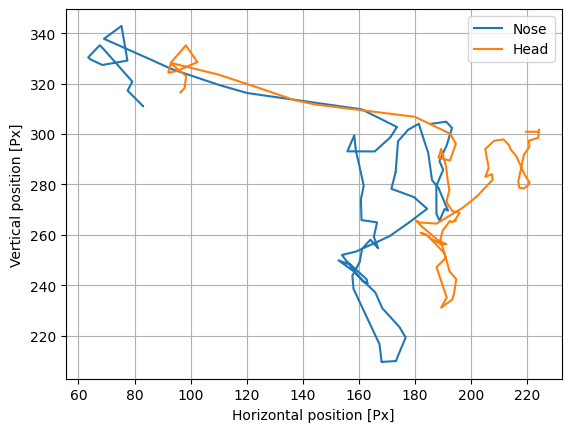

In [3]:
# Plot some points
plt.plot(*nose.positions[1000:1100].T, label="Nose")
plt.plot(*head.positions[1000:1100].T, label="Head")

plt.xlabel("Horizontal position [Px]")
plt.ylabel("Vertical position [Px]")
plt.grid()
plt.legend()

## Exploration detection from tracked positions

### Geometric detection by proximity and orientation

We choose to clasify as explorations those points which satisfy two conditions:

- The nose is close to the center of a given object (within a certain `maxDistance`).

- The angle between the head-nose vector and the head-object vector is smaller than a certain `maxAngle`.

In [4]:
# Find distance from the nose to each object
dist1 = Point.dist(nose, obj1)
dist2 = Point.dist(nose, obj2)

# Find points where the nose is close to obj1
maxDistance = 80 # pixels (4 cm)
close1 = nose.positions[dist1 < maxDistance]

# Find points where the nose is close to obj2
close2 = nose.positions[dist2 < maxDistance]

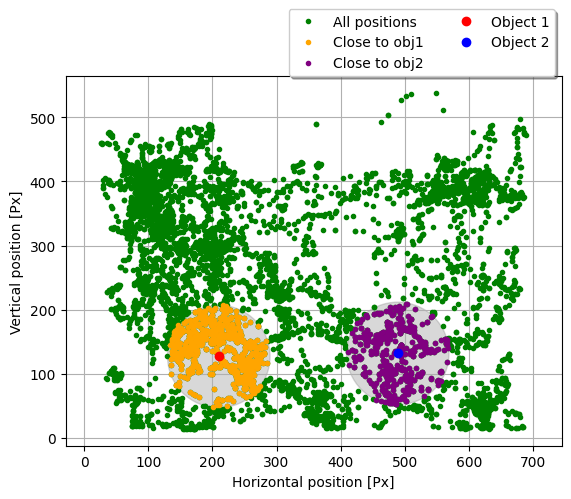

In [5]:
# Plot points, objects,
# and distance around the center of each object
fig, ax = plt.subplots()

ax.plot(*nose.positions.T, ".", label = "All positions", color = "green")

ax.plot(close1[:, 0], close1[:, 1], ".", label = "Close to obj1", color = "orange")
ax.plot(close2[:, 0], close2[:, 1], ".", label = "Close to obj2", color = "purple")

ax.plot(*obj1.coordinates, "o", lw = 20, label = "Object 1", color = "red")
ax.plot(*obj2.coordinates, "o", lw = 20, label = "Object 2", color = "blue")

ax.add_artist(Circle(obj1.coordinates, maxDistance, color = "grey", alpha = 0.3))
ax.add_artist(Circle(obj2.coordinates, maxDistance, color = "grey", alpha = 0.3))

ax.axis('equal')
ax.grid()
ax.set_xlabel("Horizontal position [Px]")
ax.set_ylabel("Vertical position [Px]")
ax.legend(bbox_to_anchor = (0, 0.2, 1, 1), ncol=2, fancybox=True, shadow=True)

In [6]:
# Compute normalized head-nose and head-object vectors
head_nose = Vector(head, nose, normalize=True)
head_obj1 = Vector(head, obj1, normalize=True)
head_obj2 = Vector(head, obj2, normalize=True)

# Find the angles between the head-nose and head-object vectors
angle1 = Vector.angle(head_nose, head_obj1) # deg
angle2 = Vector.angle(head_nose, head_obj2) # deg

# Find points where the mouse is looking at obj1
maxAngle = 50 # deg
looking1 = nose.positions[angle1 < 50]

# Find points where the mouse is looking at obj2
looking2 = nose.positions[angle2 < 50]

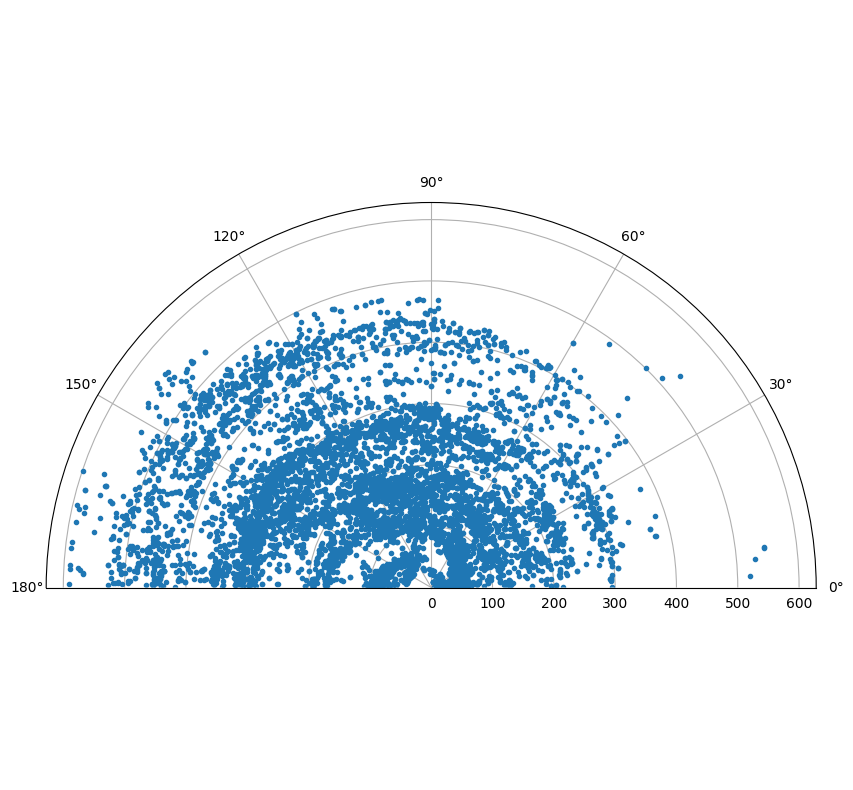

In [14]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection' : 'polar'})

ax.plot(np.deg2rad(angle1), dist1, ".")

ax.set_thetamax(180)